In [3]:
import sys
sys.path.append('../')

import meta_dataloader.TCGA

import models.mlp, models.gcn
import numpy as np
import data.gene_graphs
import collections
import sklearn.metrics
import sklearn.model_selection
import pandas as pd
%load_ext autoreload
%autoreload 2

In [47]:
from sklearn.manifold import TSNE
from   sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
emb_path = "../data/datastore/el_vectors.csv"
embedding_data = pd.read_csv(emb_path)
embedding_data = embedding_data.set_index('Gene_ID')
emb_vectors = []
missing = 0
for gene in embedding_data.index:
    if gene in embedding_data.index:
        emb_vectors.append(list(embedding_data.loc[gene]))
    else:
        emb_vectors.append(list(np.random.random(embedding_data.shape[1])))
        missing += 1
print("Missing embeddings ", missing)

Missing embeddings  0


In [11]:
tsne2 = TSNE(n_components=2, random_state=0)
prjected_tsne = tsne2.fit_transform(emb_vectors)

In [49]:
path = "../data/MBdata_all.csv"
df = pd.read_csv(path)

In [50]:
df = df[df.Pam50Subtype != '?']
target = df.pop('Pam50Subtype')
pam50_lables = {
    'Normal': 0,
    'LumA': 1,
    'LumB': 2,
    'Basal': 3,
    'Her2': 4
}
target = target.apply(lambda x: pam50_lables[x])

# df = df[df.iC10 != '?']
# target = df.pop('iC10')
# labels = {
#     '4ER-': 4,
#     '4ER+': 11
# }
# target = target.apply(lambda x: labels[x] if x in labels else int(x))

features = df.filter(regex='^GE.*')
features = features.astype('float64')
print(features.shape)

(1974, 24368)


In [421]:
def normalize(df):
    r = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value != min_value:
          r[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return r

In [422]:
features = df.filter(regex='^GE.*')
features = normalize(features)
features.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
features = features.rename(columns={g: g[3:] for g in list(features.columns)})

In [1]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features, 
                                                                            target.to_numpy(), 
                                                                            stratify=target.to_numpy(),
                                                                            train_size=1500,
                                                                            test_size=400,
                                                                            shuffle=True,
                                                                            random_state=0
                                                                             )
X_test, X_valid, y_test, y_valid = sklearn.model_selection.train_test_split(X_test, 
                                                                            y_test, 
                                                                            stratify=y_test,
                                                                            train_size=200,
                                                                            test_size=200,
                                                                            shuffle=True,
                                                                            random_state=0
                                                                           )

NameError: name 'sklearn' is not defined

In [54]:
embeddings_name = 'dl2vec'

In [434]:
graph = data.gene_graphs.OntologyGraph(neighbors=10, embeddings_name='dl2vec', relabel_genes=False, randomize=True)
adj = graph.adj()

 loading from cache file/auto/homes/mt675/gene-graph-conv-onto/data/graphs/ontology_dl2vec_10.adjlist.gz
Randomizing the graph


In [435]:
# gene = 'ESR1'
num_genes = 20000
# neighbors = graph.bfs_sample_neighbors(gene, num_genes*1.2)
neighbors = graph.nx_graph
intersection_nodes = np.intersect1d(neighbors.nodes, features.columns)

X_train = X_train[list(intersection_nodes)[:num_genes]].copy()
X_valid = X_valid[list(intersection_nodes)[:num_genes]].copy()
X_test = X_test[list(intersection_nodes)[:num_genes]].copy()

toremove = set(neighbors.nodes)
toremove = toremove.difference(intersection_nodes)
neighbors.remove_nodes_from(toremove)

KeyError: "['ANKRD9', 'ADAM18', 'FER1L4', 'PTCD1', 'STK31', 'ZDHHC4', 'PLEK2', 'FAM20C', 'KLHL30', 'PCDH17', 'GPR89A', 'DUSP14', 'PLEKHG6', 'MUC2', 'SETD5', 'TMEM134', 'SYPL1', 'FAM174B', 'KRTAP3-1', 'MYL6B', 'PAQR4', 'PCDHB1', 'GAS2L3', 'ARL5B', 'FAM163A', 'CWH43', 'C8G', 'TEX19', 'KLRG2', 'KDM3B', 'SCAMP4', 'PRRG3', 'SLC26A10', 'ARMCX6', 'SLC24A3', 'POLR2A', 'ISM1', 'FAM185A', 'FBXW4', 'PRELID2', 'RNF214', 'FAM76A', 'SECISBP2L', 'GPATCH8', 'TRNP1', 'ADAM21', 'GIGYF1', 'CCDC125', 'TSPAN3', 'CDH26', 'POU4F3', 'CPXM1', 'MYO7B', 'CLEC1A', 'GPR174', 'SPTA1', 'DND1', 'C20orf85', 'CYFIP2', 'ZNF609', 'CXXC4', 'FAM89A', 'CNOT6L', 'HERPUD2', 'FAM104A', 'RAB31', 'ZMYM4', 'CCDC87', 'TNFRSF19', 'TMEM140', 'B2M', 'PCDHB16', 'C11orf16', 'PPP1R12B', 'C1QL2', 'CWC25', 'CCDC134', 'CD37', 'C11orf24', 'PECAM1', 'FGD5', 'VEPH1', 'NDN', 'PIK3C2G', 'SLC16A14', 'GPR3', 'MMEL1', 'REC8', 'SYCP2L', 'HIC2', 'ECE2', 'PIK3R1', 'IRGQ', 'SPINK7', 'ZCCHC7', 'ZBTB26', 'SPTBN4', 'FAM189A1', 'KRTAP17-1', 'TMEM151B', 'ITPRIPL1', 'SALL2', 'UBXN10', 'MPST', 'ZNF646', 'LIMD2', 'KRTAP10-7', 'TMEM63A', 'TM4SF19', 'PBXIP1', 'TBC1D12', 'ARRDC4', 'TBC1D2B', 'PRKCSH', 'ZNF239', 'NKAIN1', 'TMPRSS13', 'ANKMY1', 'DPY19L4', 'CLDN8', 'PLEKHG1', 'BPHL', 'CA13', 'TSPAN13', 'RNF212', 'LY6G5C', 'TMEM42', 'GARNL3', 'C1QL4', 'SYNGR4', 'ZNF704', 'TMEM161A', 'LRRC30', 'ZNF483', 'IMPG2', 'WSCD2', 'CA14', 'TMPRSS3', 'CPNE5', 'TCERG1L', 'ENPP5', 'KIF18B', 'GPR12', 'DENND3', 'SULT1C4', 'NGRN', 'SLC25A26', 'PARP6', 'INPP5F', 'CDKL1', 'RASSF10', 'RABGAP1L', 'PRDM11', 'L3MBTL3', 'CLDND1', 'FOXA2', 'DRD1', 'TYW1B', 'CCL3', 'DNAH6', 'TICAM2', 'TMEM168', 'SEBOX', 'TINAG', 'FCRLB', 'SATL1', 'C4orf51', 'ZBTB37', 'WDR13', 'FLRT1', 'GPR101', 'OTOP3', 'TMEM108', 'ODF3L1', 'PRSS35', 'OR5AR1', 'ELOVL7', 'TPD52L3', 'NUDT18', 'SLC17A9', 'FAM83D', 'ANKRD12', 'TMEM41B', 'RTKN2', 'C10orf53', 'VWA5A', 'TCEAL8', 'FAM114A2', 'EFNB2', 'TMEM119', 'RCN3', 'JAZF1', 'PARP16', 'SGK3', 'RAVER1', 'C19orf48', 'KRT78', 'FAM13C', 'FAM50A', 'TMTC2', 'TTC14', 'SOCS7', 'C1orf53', 'FAT3', 'ADAD2', 'OSTF1', 'TTC32', 'CCDC127', 'ABCA9', 'YBEY', 'KRT9', 'REM2', 'TRIL', 'LRRC14B', 'UGT2A1', 'CDHR5', 'PHACTR3', 'SCUBE1', 'TCF19', 'INO80', 'TTC9B', 'CDH16', 'TRIM40', 'IARS2', 'SLC27A3', 'FAM53B', 'CCDC117', 'NOTO', 'MT1B', 'ARHGEF33', 'LCN8', 'ATP1A3', 'THNSL2', 'PTPN9', 'SPECC1L', 'EML3', 'TMEM185A', 'TMEM54', 'LMBRD1', 'ANXA8', 'CMC1', 'ATL2', 'AMMECR1L', 'LIX1L', 'ASPHD1', 'SAMD13', 'ANKFN1', 'ANKRD22', 'GTF2IRD2', 'MEX3D', 'TMED8', 'FAM166A', 'BOP1', 'TMEM132E', 'TCHP', 'FCGR3B', 'SDR39U1', 'PRTG', 'KRT25', 'ZDHHC24', 'DRAM1', 'OTOR', 'TMEM14C', 'FAM71E2', 'POM121', 'FBLL1', 'SPARCL1', 'CYB5D2', 'OPLAH', 'IQCK', 'DCP1A', 'ART4', 'SEZ6', 'ZIC4', 'PLEKHB2', 'TRIT1', 'AIDA', 'MZF1', 'KITLG', 'TEX9', 'MAP6', 'FCHSD1', 'LETMD1', 'HOXA1', 'SLC4A5', 'TMEM52', 'TMEM184B', 'THYN1', 'C10orf120', 'HMGB4', 'SFXN5', 'USH1G', 'KCTD7', 'SNX19', 'C17orf107', 'GABRQ', 'C15orf62', 'ASPHD2', 'CCDC80', 'FBXW10', 'ADORA3', 'ARID3C', 'JMJD8', 'SYT16', 'ZC3H7B', 'CCDC142', 'TIFAB', 'TRIM42', 'BEND3', 'TMUB2', 'PCDHB4', 'ABCC4', 'FBXO46', 'C1QTNF2', 'C19orf54', 'PHLDB1', 'C16orf86', 'OTOP2', 'TAF1C', 'TBC1D21', 'TFPI2', 'ZNF628', 'CUEDC1', 'CYP2W1', 'AFM', 'C1orf141', 'C19orf12', 'PLSCR3', 'CDRT4', 'CYB561D2', 'SAAL1', 'KRT23', 'ANXA10', 'TMEM154', 'RERG', 'SEMA6B', 'TMEM123', 'KCTD16', 'CCDC62', 'ZBTB8B', 'FANK1', 'RBM42', 'THUMPD3', 'TMEM161B', 'C7orf50', 'C8orf82', 'ZSCAN2', 'ZNF467', 'ZCCHC4', 'LRRC7', 'VPS8', 'FERD3L', 'ZFYVE27', 'TADA2A', 'SLC25A11', 'CLEC18C', 'CYYR1', 'DGKK', 'RIMS2', 'RWDD2B', 'EIF4G3', 'HOXC10', 'NUDT17', 'TEAD1', 'SCN7A', 'IQUB', 'MAGEE1', 'SHISA8', 'NOL4', 'PCMTD2', 'ACBD5', 'CBLN4', 'TMEM74', 'RAP1GAP2', 'GOLM1', 'KIAA0895L', 'BRAT1', 'FAM135A', 'GPATCH3', 'HDHD2', 'C6orf120', 'CCL4', 'ABHD13', 'FAM170B', 'ZNF281', 'AGBL5', 'FICD', 'PMF1', 'SLC38A11', 'CRYBB1', 'GLOD5', 'SH3BGR', 'SEC14L2', 'CTNNA3', 'TEPP', 'TMEM71', 'AGAP3', 'TPPP3', 'MDGA2', 'PAQR6', 'C16orf72', 'SUSD1', 'CAPRIN2', 'ALX4', 'CPZ', 'ZNF185', 'B3GNT6', 'FBXO36', 'C11orf42', 'SLFNL1', 'GPR155', 'LRRC20', 'HHATL', 'SLC25A30', 'ICA1L', 'IGFN1', 'ZBTB49', 'EBPL', 'C11orf68', 'OGFOD1', 'MYOM3', 'TMEM170A', 'SCAMP1', 'HRNR', 'KLHDC7B', 'RAB37', 'CHIC1', 'SCARF2', 'EML5', 'HELB', 'SHANK3', 'KRTAP12-2', 'PRPF38B', 'TMUB1', 'PLAC8L1', 'ALPK2', 'DPEP3', 'RNF183', 'ZNF48', 'PTP4A1', 'OTUD6B', 'OR51B2', 'KIF24', 'PATL2', 'HINT2', 'TTL', 'SHE', 'ZSWIM5', 'KLHDC9', 'EFR3B', 'GFRAL', 'LYG1', 'ZNF518B', 'SLC37A4', 'KRT82', 'GPHB5', 'FLYWCH2', 'THPO', 'GSG1L', 'FRMD5', 'AFAP1L2', 'PLCB4', 'SUSD5', 'ENTPD7', 'MOSPD1', 'SPTY2D1', 'FREM2', 'RESP18', 'NRSN2', 'EPHX4', 'PRF1', 'PRG3', 'SLC18A2', 'C17orf58', 'CTXN3', 'RFX7', 'STON1', 'GPR162', 'GSTT1', 'TMEM185B', 'KLF7', 'PXMP2', 'TIGD2', 'SPATA1', 'C11orf80', 'C16orf90', 'GLT8D2', 'POU3F4', 'ZNF700', 'KIAA0754', 'ZBTB3', 'C1orf105', 'TMPRSS15', 'SNX31', 'RDM1', 'SLCO3A1', 'KCNN4', 'ANKRD29', 'TMEM53', 'CYP19A1', 'SYT3', 'IQSEC3', 'C16orf87', 'OR10A6', 'TMC5', 'MUC1', 'S1PR2', 'FAM43B', 'METTL7A', 'NRM', 'ZNF618', 'RNASE12', 'VPS29', 'EVX1', 'C8orf58', 'ZFYVE21', 'MORC3', 'BPIFA1', 'C9orf24', 'ZXDB', 'TPPP', 'MSMB', 'CYP4F12', 'RSAD1', 'ALAS2', 'LRRC8B', 'KIAA1210', 'CCDC74A', 'PANX3', 'FAM83F', 'CASP14', 'SLC22A17', 'PAQR7', 'ERAL1', 'ESPNL', 'KLHL28', 'TMEM234', 'FRK', 'C1QTNF4', 'LIMCH1', 'ZNF780A', 'SLC45A4', 'TC2N', 'GPIHBP1', 'LMTK3', 'SBK1', 'C11orf96', 'CD177', 'TGM5', 'PPM1M', 'KANK3', 'KRT39', 'UBTD1', 'C6orf89', 'MTBP', 'PTP4A2', 'C7orf25', 'GPRC5D', 'PRR7', 'PMFBP1', 'KBTBD3', 'LGALS12', 'TMEM200A', 'TOR1AIP1', 'DACH1', 'GPR137B', 'SLC25A2', 'GGA3', 'CYP4F8', 'PKD1L2', 'KCNT2', 'TCP11L1', 'KRTAP5-5', 'FASTKD1', 'PRSS38', 'NECAB2', 'RNFT1', 'RNF151', 'SIDT1', 'SCRN2', 'ADAM33', 'UACA', 'TGM7', 'ALDOA', 'CXorf56', 'RPS6KL1', 'KIAA1191', 'C3orf20', 'RC3H2', 'SLC5A9', 'SYTL3', 'ARMC10', 'LYRM2', 'CYFIP1', 'IGFBPL1', 'DPP3', 'ABHD15', 'ZDHHC19', 'C5orf15', 'KRTAP15-1', 'HOXA6', 'CCDC157', 'NUAK2', 'SLFN5', 'RPGRIP1L', 'TRABD', 'C1orf158', 'LMOD2', 'ANKRD33', 'EPS8L1', 'KLHL35', 'OVOL2', 'TMEM201', 'ABCA13', 'MTFR1', 'TTC39A', 'LDLRAD2', 'ADIG', 'TMEM116', 'ONECUT2', 'CRIP2', 'CPA6', 'RNASE11', 'PROM2', 'CLMN', 'TMEM169', 'URM1', 'MICALL2', 'GPRC5B', 'LHB', 'STK33', 'CBY3', 'CREB3L1', 'PLD6', 'COPZ2', 'CRYBA2', 'MT1M', 'RNF215', 'CELF2', 'C9orf43', 'PLBD1', 'HSPB2', 'ZDHHC11B', 'KRTAP2-1', 'ATAD1', 'DOCK2', 'CNTNAP4', 'AFF3', 'HOXB9', 'DENND5B', 'PCDH11X', 'ABHD2', 'C5orf34', 'IRGC', 'CCDC51', 'ADAM6', 'CHRDL2', 'GRAMD1C', 'TSSK6', 'DENND4A', 'BTBD3', 'CCDC150', 'REEP2', 'ITGB3', 'SLC44A4', 'GRAMD1A', 'ZBTB39', 'TSTD2', 'NLN', 'LANCL3', 'TMEM9B', 'KCNJ6', 'FAM193B', 'KCTD21', 'IFRD2', 'TMEM51', 'CPNE9', 'NUDT2', 'SLC2A6', 'BVES', 'SPPL3', 'C12orf50', 'LGALS2', 'POGK', 'PLEKHF2', 'GDF10', 'RIMS3', 'EPB41L4B', 'PITX2', 'KLF16', 'MLF2', 'HTRA3', 'CSMD1', 'GFOD2', 'NKX1-2', 'ANKRD34B', 'SPATA6', 'SPHKAP', 'RIPPLY2', 'TSGA10IP', 'C1orf189', 'BEST3', 'CNRIP1', 'HCFC1R1', 'C20orf173', 'MAGEL2', 'TMEM159', 'ABCA17P', 'ATP13A3', 'SPATS2L', 'MAMDC2', 'N4BP2', 'CAPSL', 'OR4C16', 'TMEM236', 'AHDC1', 'EFHD1', 'ANKFY1', 'GAS2L2', 'C17orf100', 'NNAT', 'FAM131A', 'C1QTNF6', 'NINJ2', 'NOVA2', 'N4BP2L2', 'RPS10', 'LRP11', 'ZDHHC23', 'CUTA', 'ZFHX3', 'FAM184A', 'FREM1', 'NHSL2', 'C6orf58', 'THG1L', 'FAM53A', 'MAPKAPK5', 'CCNYL1', 'GPRIN3', 'AADAC', 'MAP7D3', 'TNK1', 'LMBRD2', 'DOHH', 'PNPLA5', 'STAC2', 'EPHX3', 'TMEM196', 'ZBTB44', 'HMBS', 'ZNF672', 'FAM126B', 'SYNPO2', 'CRCT1', 'MYNN', 'CYP26C1', 'SLC7A14', 'UGT3A2', 'SNED1', 'PLP1', 'IAH1', 'PPP1R2', 'TMEM62', 'ZDHHC11', 'RTBDN', 'ANGPTL7', 'BEAN1', 'ZBED3', 'TMEM190', 'ERICH1', 'NRARP', 'DDX6', 'MORN5', 'FOXD2', 'KLHL18', 'ZNF35', 'RBP7', 'CAND1', 'CLEC4F', 'LRRC36', 'ABTB2', 'PLCXD1', 'AKIRIN1', 'SH3YL1', 'METTL21C', 'SPRR4', 'GPR141', 'KRTAP1-3', 'CPM', 'ARHGEF40', 'MYPOP', 'IFFO1', 'GPR151', 'DLX5', 'NEK4', 'SERPINA9', 'PLEKHF1', 'NACC2', 'FGFBP1', 'ACBD6', 'TMEM45A', 'PCDHB11', 'PIGC', 'APOLD1', 'OLFML3', 'TEKT5', 'C11orf58', 'SPPL2A', 'GTPBP8', 'VNN3', 'C2CD2L', 'KLHL14', 'ORAI1', 'CCDC78', 'TMEM47', 'C1orf43', 'KIAA2026', 'MIPOL1', 'ZFAT', 'SLC16A2', 'KRTAP4-8', 'GPR142', 'DEK', 'EPDR1', 'PGPEP1L', 'C6orf118', 'CPNE6', 'C21orf91', 'TMEM106C', 'FAM161A', 'NWD1', 'TTLL11', 'ZKSCAN2', 'MDP1', 'MYH6', 'TMEM121', 'ZNF236', 'DYDC1', 'PRR23A', 'SLC48A1', 'NFKBID', 'EXOC8', 'CCDC66', 'CPA5', 'EPS8L3', 'LTK', 'LYSMD2', 'GSS', 'IL17A', 'PALM3', 'KIAA0895', 'SYNRG', 'SPZ1', 'SLC35F2', 'PHTF2', 'FRAS1', 'SLC25A46', 'TMEM183A', 'FAM118B', 'METTL2A', 'SUSD4', 'ZDHHC14', 'SLITRK2', 'SAMD4A', 'KANK2', 'TMEM217', 'GMEB2', 'TMEM117', 'BTBD10', 'ZNF474', 'TREX1', 'NOP16', 'FSIP2', 'TBC1D19', 'CNPY4', 'CLCN6', 'ABCG5', 'CLEC12B', 'OR8G5', 'GPR157', 'FER1L5', 'VSIG10', 'DEXI', 'GAS7', 'SLC45A1', 'MRPS21', 'PI15', 'ANTXR1', 'C15orf41', 'CATSPER2', 'FBXO24', 'OSBPL8', 'C12orf75', 'PLEKHG3', 'ACP6', 'ADAMDEC1', 'TARM1', 'SSC5D', 'ZNF322', 'CCDC84', 'TTC29', 'RPL28', 'SLC12A9', 'NEURL2', 'GPR19', 'CC2D1B', 'NECAB1', 'ZNF251', 'WFDC2', 'METTL5', 'PI4KA', 'ZNF7', 'CTC1', 'SLC26A4', 'SPAG7', 'KLHL6', 'MAML2', 'C22orf39', 'RUFY4', 'PDZD2', 'ZSCAN12', 'PDC', 'CDH4', 'POLDIP2', 'CRISPLD2', 'TMEM174', 'TMEM69', 'SCUBE3', 'KCNK13', 'FAM71D', 'FAM155B', 'TBC1D22A', 'YTHDF3', 'TMEM39B', 'FAM133B', 'DENND2C', 'OR52R1', 'OR5R1', 'AGBL4', 'FTMT', 'ZXDC', 'ZNF428', 'ZNF275', 'TBC1D17', 'RHBDD3', 'ZNF879', 'PARP8', 'CEP57L1', 'DLK2', 'STK10', 'ITGBL1', 'ZBTB8A', 'SLC38A10', 'SPINK14', 'ELFN1', 'NEK10', 'R3HDM2', 'FAM162A', 'PITPNC1', 'TMEM205', 'AFG3L1P', 'MRM1', 'NFXL1', 'LRRC71', 'RSRC2', 'ZDHHC1', 'ZNF658', 'C9orf16', 'ARL5C', 'TM4SF5', 'NPM3', 'DUSP21', 'S100Z', 'MLLT6', 'GPR87', 'C2orf76', 'CLEC11A', 'ANO3', 'MACROD1', 'SCAMP5', 'PRR15L', 'LENEP', 'VRTN', 'SIK3', 'MYO19', 'DNAJC27', 'TCEAL3', 'RPS6KA5', 'TRAFD1', 'C1orf185', 'CCDC28A', 'SLC35F3', 'CASC1', 'PCDHB14', 'NEUROD6', 'ZMYM2', 'DHRS7', 'STK32C', 'C17orf50', 'PLA2G4C', 'STC2', 'DGAT2L6', 'PHYHD1', 'CRELD1', 'FETUB', 'ARMC7', 'RHEBL1', 'PHLDB3', 'F8A1', 'ACRBP', 'OR8G1', 'NIPAL2', 'PHF3', 'SLC35F1', 'FAM71A', 'TBC1D9B', 'TMEM33', 'KIAA1958', 'C11orf95', 'LRRC45', 'CDKL3', 'ABCG4', 'PUSL1', 'KRTAP3-3', 'ZNF341', 'CA11', 'COL9A3', 'KRT75', 'SH3BP5L', 'C10orf82', 'TMEM59', 'SPATA7', 'ZNF131', 'TMEM215', 'RIBC1', 'KCTD8', 'ANKRD34C', 'ZBTB5', 'GGN', 'DYNLL2', 'CDC42SE1', 'CCDC126', 'SERPINB12', 'TBC1D10C', 'C16orf54', 'C17orf80', 'PPP1R9B', 'ZCCHC3', 'LENG9', 'MGAT4C', 'ANGPTL6', 'MUC13', 'FRS2', 'C16orf71', 'CHCHD5', 'PRRG4', 'DTWD1', 'HHIPL2', 'LMBR1L', 'CRYGN', 'STC1', 'CDHR2', 'VPS45', 'RNF169', 'FSCN2', 'BTBD8', 'ISG15', 'FILIP1L', 'GIN1', 'NRN1L', 'C14orf93', 'FAM107B', 'SYTL5', 'SH3TC1', 'TMX4', 'DUS3L', 'SPRYD4', 'TEX13A', 'CYP4X1', 'RNF170', 'KRT72', 'SPINK13', 'KRTAP8-1', 'RBFA', 'ADCK1', 'PTMS', 'C5orf24', 'TMEM232', 'SLC2A12', 'TSPAN17', 'AQP12B', 'FCAMR', 'FAM167B', 'KIAA0040', 'ANO8', 'AKIRIN2', 'SLC6A6', 'MICALCL', 'NPY6R', 'SLC8A3', 'KRT28', 'ERCC5', 'C9orf135', 'ZBTB48', 'C5orf51', 'ZNF407', 'LYSMD1', 'TBCCD1', 'KLK9', 'SLC44A3', 'HRCT1', 'ODF3L2', 'CKAP2L', 'CTLA4', 'ZNF518A', 'MPEG1', 'ZC3H12B', 'KRTAP1-1', 'SLC35F4', 'ANKS6', 'NLRP10', 'SDCBP2', 'ENPP1', 'NOL7', 'FAM117B', 'SLC25A47', 'ZNF93', 'HSDL1', 'RIMBP3', 'MPV17L2', 'TM9SF3', 'PLSCR4', 'PLEKHG4', 'POLR2H', 'CCNJ', 'EARS2', 'OAZ1', 'PCBP3', 'ARMC6', 'SPINK6', 'C1orf54', 'C6orf141', 'GLYCAM1', 'FAM43A', 'STAP2', 'MB21D2', 'IGSF9', 'TMCC2', 'VASH2', 'ZNF845', 'ELMOD2', 'FAM180A', 'CCDC158', 'ARMCX5', 'OR5V1', 'LSAMP', 'OST4', 'KCNK16', 'RINL', 'KRT80', 'ZNF358', 'DAB1', 'C9orf153', 'RFWD3', 'HAPLN2', 'ZBTB9', 'ZCWPW2', 'PODN', 'OLFML2B', 'BIN2', 'PCDHB2', 'CMBL', 'PEAK1', 'CD5L', 'JPH4', 'FAM20B', 'YTHDF1', 'SLC38A8', 'ATP8B1', 'PCGF2', 'TMEM139', 'HOXA11', 'TSPAN10', 'MS4A15', 'SUN3', 'GPR158', 'STOX1', 'KRTCAP3', 'ZC3H7A', 'PRIMA1', 'DUSP13', 'PRRT4', 'GRTP1', 'TULP4', 'ETV2', 'SLC17A3', 'PRSS56', 'NUDT22', 'PXMP4', 'SASH1', 'PARP11', 'OR1B1', 'TMEM158', 'PHTF1', 'TSGA10', 'VPS13B', 'KRTDAP', 'ACACA', 'GRIPAP1', 'JKAMP', 'PLXDC2', 'GPR137C', 'MANBA', 'TTC25', 'ANKRD13B', 'ZBED4', 'ARHGAP18', 'SLC41A1', 'C17orf98', 'C4orf48', 'ABHD8', 'CCDC69', 'TTC17', 'SLC16A12', 'OR5H6', 'ANO7', 'PRSS37', 'LYNX1', 'FSTL4', 'AIG1', 'NTF4', 'TMEM87B', 'C2orf66', 'ODF2L', 'MAP6D1', 'VWC2', 'TMCO4', 'MPZL2', 'RASSF7', 'KAZALD1', 'CPNE7', 'FHDC1', 'HEATR3', 'DBX1', 'GJA10', 'GSDMC', 'RNF166', 'ASTL', 'SIPA1L3', 'FAM187B', 'DUSP15', 'PLEKHA6', 'PDE1A', 'TMPRSS12', 'DDAH1', 'CLSTN2', 'TMEM14A', 'STK11IP', 'PLEKHH3', 'DPY19L1', 'TMEM63C', 'RBM41', 'PRAP1', 'PHYHIPL', 'SRRT', 'POLR1C', 'ARRDC5', 'DCUN1D4', 'BTG3', 'SIDT2', 'SLC15A2', 'STYXL1', 'SPON1', 'SEC14L4', 'OAF', 'LBH', 'SLC38A7', 'IQCF5', 'C1orf198', 'CPNE3', 'KLHL26', 'ZNF585B', 'SAMSN1', 'SSX4B', 'DPY19L3', 'RNF115', 'UBE3A', 'PAMR1', 'SLC25A38', 'CDKL2', 'TMSB15B', 'SYPL2', 'CCDC113', 'SYT14', 'EMP3', 'METTL7B', 'C4orf17', 'SH3RF2', 'CARHSP1', 'ZNF524', 'GLCCI1', 'ZBTB38', 'KRT79', 'KRT33B', 'SLC6A9', 'ZAN', 'EEPD1', 'KLK12', 'LYRM1', 'SLCO4A1', 'ADNP2', 'BEND5', 'EPS8L2', 'OTOGL', 'GDAP2', 'RUNDC3B', 'RNF10', 'CCDC160', 'HNRNPA1L2', 'TMEM203', 'RSPRY1', 'ID4', 'PCDH20', 'PLEKHJ1', 'WDR41', 'DCST2', 'SLC41A3', 'EFHC2', 'GTSF1', 'TSPAN32', 'SCAF1', 'GRID1', 'TECPR2', 'PKD2L2', 'TAP2', 'C6orf47', 'TBC1D24', 'S100A3', 'VWC2L', 'ARMC4', 'ARL14', 'RBFOX3', 'EFS', 'SIGLEC12', 'DDX52', 'MANEA', 'TMEM9', 'ZNF648', 'C12orf49', 'TRPM7', 'LHX1', 'RNF133', 'SHISA6', 'FLG2', 'SLC25A42', 'RPAP2', 'C12orf71', 'ERN2', 'FAM47C', 'ZNF780B', 'CORO2B', 'ALDOB', 'SBNO2', 'ZNHIT6', 'TMEM79', 'SVOP', 'C11orf1', 'TRIML2', 'TMEM163', 'LY6D', 'SUSD2', 'ELK3', 'SUSD3', 'TMEM125', 'ECEL1', 'DEF8', 'ARID3B', 'TLR5', 'DNASE1', 'RBM43', 'SH2D7', 'PDZRN3', 'SLC46A1', 'CYP1B1', 'ZNF277', 'SMTNL2', 'TRIM65', 'DPPA2', 'ZNF580', 'SPIC', 'GNAZ', 'C9orf131', 'SLC25A45', 'TMEM131', 'MTMR9', 'ZPLD1', 'RPS7', 'SLC2A13', 'IGF1R', 'COL19A1', 'PGAP2', 'KIAA1109', 'FAM183A', 'ARMC9', 'MXRA8', 'WFDC9', 'SMPDL3B', 'TMEM95', 'CLEC9A', 'SPATA22', 'C16orf46', 'PLEKHA5', 'XKR6', 'RP9', 'ALMS1', 'CCDC83', 'PCDHGC3', 'CD52', 'BCL2L13', 'AKIP1', 'DCDC2B', 'LYSMD4', 'TMEM26', 'TMEM150B', 'ADAM29', 'GFOD1', 'GREB1L', 'AARSD1', 'CHID1', 'ATXN1L', 'AADACL4', 'C1orf146', 'PCDHB3', 'GLYATL3', 'C12orf4', 'SAMD5', 'MEG3', 'FOXC1', 'CCDC82', 'SRP72', 'APOC1', 'KNG1', 'FAM24B', 'ABHD4', 'TIAM2', 'MOGS', 'RNF141', 'TSPAN8', 'FLI1', 'RNF186', 'C12orf56', 'TMC7', 'RAB11FIP4', 'TTYH3', 'BEND6', 'SLC22A25', 'BMPR1A', 'TEKT4', 'LILRA5', 'UBE2T', 'DAPL1', 'FAM71F2', 'NR2E3', 'MOBP', 'EMX2', 'CLDND2', 'TMEM202', 'HAUS7', 'SERPINE3', 'GLIS2', 'ASXL3', 'HDDC2', 'ANTXRL', 'RPRML', 'C9orf50', 'GNB1', 'CCDC162P', 'EME2', 'FKBP15', 'MORN1', 'C19orf53', 'C6orf62', 'NXPH2', 'GIPC3', 'LCN15', 'ACSBG2', 'MFSD3', 'ZDHHC20', 'SVOPL', 'GRHL3', 'KRT15', 'KLK15', 'MICAL1', 'PCP4L1', 'BBX', 'KRTAP13-1', 'CSTL1', 'UCMA', 'ARFRP1', 'MCOLN3', 'PRRT1', 'SOX21', 'SH2D5', 'ZFP57', 'FNBP4', 'CLEC3A', 'BTBD11', 'RNASE9', 'NCKAP5L', 'TTLL2', 'MMP12', 'GLT8D1', 'BNC1', 'DOC2A', 'MORN3', 'MTMR11', 'CFC1B', 'RBM15B', 'FAM135B', 'TM7SF3', 'TSPYL5', 'TTYH1', 'HMX3', 'TMEM60', 'USP53', 'EBF3', 'CSRNP3', 'ZSWIM3', 'DTD1', 'ACY3', 'TMEM129', 'SLC25A44', 'RMND1', 'HMBOX1', 'BTBD16', 'OR5AP2', 'KRTAP11-1', 'CERCAM', 'VMAC', 'TRIM38', 'ZBTB47', 'TPTE2', 'PPDPF', 'SH3BGRL3', 'OR52B4', 'C16orf89', 'RAPGEFL1', 'CNKSR3', 'TMPRSS11F', 'JOSD2', 'NEK11', 'BARHL2', 'BTG4', 'SACS', 'ZNF2', 'MRO', 'TMEM192', 'STARD7', 'SLC36A4', 'CCPG1', 'ZSWIM1', 'MFSD6L', 'YDJC', 'KLK10', 'ZNF711', 'ANKRD11', 'UNC50', 'TBC1D22B', 'CCDC33', 'SEMA3B', 'NDUFC1', 'ZFR2', 'FRMD4B', 'BCL2L15', 'KCNK4', 'TMEM184C', 'GCHFR', 'C12orf40', 'SLC43A3', 'EPPK1', 'ZFHX2', 'NETO2', 'TMEM182', 'C20orf194', 'OLIG1', 'SPATA19', 'TMEM132A', 'C18orf25', 'CA5A', 'LRRN4CL', 'FOXB2', 'CUTC', 'CYGB', 'SH3RF3', 'DHRS3', 'STON2', 'SMAGP', 'TMEM44', 'ZMYND12', 'TMC2', 'OVCH2', 'CYP4F11', 'ZCCHC24', 'ABCC10', 'ZDHHC16', 'SLC24A2', 'TMEM61', 'AKNAD1', 'EID2B', 'SLC25A15', 'PRDM8', 'THEM5', 'COX6B1', 'VWDE', 'METRN', 'WDR93', 'PRAMEF12', 'WDR17', 'TTBK1', 'C1orf115', 'SLC27A6', 'APLN', 'HIGD1A', 'PLCD3', 'STOX2', 'TBRG4', 'SERINC2', 'EGFL8', 'SLC37A3', 'KLHL34', 'TMPRSS5', 'GCLC', 'TPPP2', 'ZSWIM4', 'RFTN2', 'RTTN', 'TRIM61', 'FOXC2', 'PIK3IP1', 'USP50', 'MFSD9', 'SLCO4C1', 'ZNF324B', 'KCTD18', 'RBM11', 'PNMA1', 'TTC36', 'FASTKD3', 'ZNF865', 'OCIAD2', 'SLC15A3', 'SLC44A1', 'CLEC18A', 'GPR171', 'C21orf62', 'ZFP36', 'LYG2', 'ENOX2', 'PRR3', 'PRSS27', 'SLC14A1', 'VSIG1', 'SNN', 'ZNF334', 'ERAP1', 'IFI27L2', 'ARL5A', 'KLHDC7A', 'SLC25A28', 'SNX29', 'TMEM102', 'TMEM200B', 'ARMC5', 'RPS17', 'HR', 'TMEM132C', 'CNTNAP5', 'RNF222', 'PLAC9', 'KLHDC8A', 'MRAP2', 'OR51F1', 'SLC25A33', 'ARHGAP42', 'KRCC1', 'ZNF768', 'ARHGAP23', 'CPNE1', 'C3orf18', 'ZNF260', 'SHISA7', 'CRISPLD1', 'HEPACAM2', 'ZDHHC22', 'GBP5', 'GIPC2', 'KPRP', 'SLC16A11', 'SLAIN1', 'ANKRD26', 'TSPAN15', 'ST3GAL1', 'ZFP41', 'NUDT3', 'ASB3', 'TIMD4', 'CPNE8', 'TMEM179', 'SYNPO2L', 'CBLB', 'TOX4', 'WTIP', 'FBXW2', 'NUCB2', 'FITM1', 'ATP9B', 'TTC24', 'GDPD4', 'KCNT1', 'JMJD4', 'TMEM138', 'TUSC3', 'OR2A42', 'OTX1', 'RGL3', 'DLG4', 'SLC20A1', 'GPATCH2', 'LYPLAL1', 'TAAR9', 'ANKRD10', 'TMC3', 'ELMOD3', 'ARMC2', 'ZNF253', 'TPM2', 'TMEM208', 'MORN2', 'MFSD6', 'ZFP64', 'FAM186A', 'SLC25A32', 'C22orf46', 'ADCK5', 'LINGO4', 'OR5L1', 'HOXD10', 'TSPAN6', 'ZXDA', 'C16orf78', 'ZSCAN5B', 'PNLDC1', 'KCTD11', 'OLIG3', 'BRI3', 'ZDHHC18', 'FAM117A', 'ANKRD39', 'CHAC2', 'DMRTA1', 'ATXN2', 'CSMD2', 'CXorf66', 'MTUS1', 'DIABLO', 'TMEM64', 'ZNF385C', 'KIAA0556', 'ATP13A5', 'SRRM3', 'EML6', 'TMEM222', 'SLC16A13', 'C12orf29', 'PXT1', 'TRIOBP', 'CCDC105', 'PLBD2', 'NT5DC1', 'CBLN2', 'TMEM135', 'PGBD5', 'TMEM175', 'LCN10', 'C2orf74', 'TTC33', 'SLC44A5', 'VPS13C', 'TMEM104', 'ODF2', 'AJAP1', 'SPACA5B', 'DBX2', 'STARD9', 'PKD1L3', 'NUCB1', 'TMEM91', 'PTPRQ', 'DMRTB1', 'ATXN7', 'L3MBTL4', 'CNIH4', 'C9orf116', 'DUPD1', 'TMEM40', 'OR51G1', 'C1R', 'TMEM219', 'FAM169A', 'LYPD4', 'SLC47A2', 'BANF2', 'SPNS1', 'DUSP26', 'KRTAP27-1', 'TTLL3', 'GRHL2', 'ERLIN2', 'PLCL2', 'SLC25A40', 'SMTNL1', 'TMEM39A', 'ZNF827', 'SNHG5', 'FAM72A', 'GSX1', 'PPM1G', 'TPRA1', 'CCDC17', 'ARHGEF37', 'ASPRV1', 'SAMD11', 'TNFAIP8L3', 'PTPRE', 'SERINC1', 'LONRF3', 'FNDC8', 'SLC5A11', 'GOLGA7B', 'ARID5A', 'DNASE1L3', 'PRSS48', 'CRLF3', 'OSGIN1', 'TSPAN18', 'MYEF2', 'SLC36A1', 'DNM3', 'PROCA1', 'CCDC90B', 'FXYD4', 'TIGD4', 'RHBG', 'GRAMD4', 'BEST2', 'ABCC2', 'RNF223', 'CCDC24', 'DCX', 'TP53I11', 'TMEM207', 'TSPAN14', 'WDR86', 'SLC25A36', 'CST5', 'RBM26', 'PRDM13', 'FAM124B', 'ZNF613', 'C10orf71', 'SAMD1', 'C15orf61', 'FAM171B', 'TTLL4', 'UTF1', 'KLHL7', 'CDC42BPG', 'RARRES1', 'FATE1', 'SLC16A6', 'ARHGEF38', 'TMEM165', 'C2orf42', 'SREK1IP1', 'MFAP3L', 'TTLL10', 'PI4KB', 'PRAMEF20', 'SLC7A4', 'DYNC2H1', 'IGDCC4', 'FBXO16', 'SLCO2B1', 'OTP', 'ABCF3', 'ZNF8', 'STK32A', 'SERPINB11', 'ANO9', 'LCN6', 'MAMDC4', 'BBS10', 'SLFN14', 'POC5', 'KRTAP4-3', 'MXD3', 'C11orf65', 'TPSG1', 'UOX', 'PADI6', 'ILDR2', 'STAC3', 'PSD3', 'TAF15', 'TBX15', 'LYZL6', 'PRR13', 'MANBAL', 'RNF112', 'ZNF438', 'ATP2C1', 'ANXA9', 'WASF2', 'C1orf100', 'NAV3', 'LY75', 'CLPTM1', 'ANKRD53', 'UBXN8', 'TMEM130', 'PRSS41', 'LRP2', 'ZFAND2A', 'EMG1', 'PTPRC', 'TTC39C', 'METRNL', 'OGFRL1', 'TMIE', 'KRT73', 'JAKMIP1', 'TMED6', 'PCDHB15', 'REEP6', 'FGL1', 'RHBDD2', 'CREG2', 'CCDC7', 'C3orf22', 'SHISA3', 'GPS1', 'KLHL36', 'ME3', 'TAZ', 'OTUD6A', 'TMEM11', 'SCGB3A1', 'RTP3', 'CCDC60', 'TTC16', 'WWC2', 'LYZL2', 'SIX1', 'R3HCC1', 'TMTC3', 'MBLAC1', 'TEKT1', 'ZGPAT', 'CEACAM20', 'CBLC', 'MLLT11', 'C16orf74', 'SLC22A23', 'CA1', 'MEGF9', 'PTCD2', 'GAPT', 'FAM71E1', 'NIPAL3', 'ACBD4', 'KIAA0586', 'HS3ST6', 'CCDC103', 'JRKL', 'CAMKV', 'CHRNE', 'CLIC3', 'PIP4K2B', 'BAALC', 'NKX6-3', 'ABCC12', 'PRR11', 'MMP27', 'CTDSPL2', 'TTC34', 'SEZ6L2', 'C17orf97', 'ZIC5', 'ZNF329', 'WDR63', 'ANKRD16', 'SPRR1A', 'FOXJ3', 'ABCA6', 'SLC15A4', 'PCDHB5', 'CLEC2L', 'ZNF367', 'PHF13', 'TEX2', 'METTL6', 'GPBP1L1', 'THEG', 'CORO7', 'OLFML1', 'C14orf39', 'C9orf152', 'FBRS', 'QPCTL', 'SYT6', 'KRT81', 'C1orf127', 'CDYL2', 'POPDC2', 'SH2D4B', 'DMRTC1B', 'MATN2', 'MUC3A', 'WDR64', 'TSPAN5', 'HSPB9', 'ICA1', 'SWAP70', 'KIAA1549', 'ASCL4', 'ZNF683', 'MYCBP2', 'CPSF1', 'PDZD9', 'MRS2', 'FAM83G', 'SPPL2B', 'PLEKHN1', 'LINS1', 'IFI27', 'LIPT1', 'DBNDD2', 'CCDC42', 'HSF5', 'PRAF2', 'NCCRP1', 'LPAR4', 'OSBPL5', 'GPR179', 'C5orf22', 'MN1', 'ZNF142', 'TSPAN31', 'ANKRD13C', 'TMEM101', 'TMEM151A', 'MYADML2', 'FRMPD1', 'SYT17', 'PRAMEF7', 'ZMAT1', 'PRADC1', 'JAKMIP3', 'PCDHB7', 'VWA3A', 'F11R', 'CCL5', 'HAPLN1', 'KRT36', 'FCRL6', 'PWWP2B', 'S100A5', 'ASTE1', 'RASL10B', 'PSORS1C2', 'TMPRSS7', 'FAM81A', 'TSPAN9', 'TMEM89', 'ZNF292', 'LYPD5', 'LY6G6C', 'SLC35B3', 'ZNF365', 'ANKRD37', 'MTAP', 'TSHZ3', 'SLC5A10', 'TLCD2', 'PTCHD3', 'SMR3A', 'SMCR8', 'ANXA4', 'RBM8A', 'ALOX12B', 'ZNF784', 'VILL', 'ZNF598', 'IFIH1', 'POU5F2', 'ZNF787', 'TSPAN33', 'LETM2', 'CACHD1', 'GTDC1', 'QSER1', 'JPH3', 'MTUS2', 'KRT40', 'ZNF717', 'MRPL45', 'RAD50', 'CD99L2', 'SERAC1', 'CLEC4A', 'FAM25A', 'KIAA0232', 'EFCAB5', 'DCBLD2', 'NQO2', 'TMEM231', 'SLC35C2', 'TBC1D14', 'BSDC1', 'FOXL2', 'STK32B', 'RECQL4', 'SHISA2', 'LRP3', 'NIPAL1', 'SPATA9', 'PNMA3', 'COQ10A', 'BTBD18', 'DAND5', 'ANKRD40', 'C1orf131', 'MOSPD2', 'PHIP', 'SOX14', 'ELFN2', 'BHLHB9', 'ZZZ3', 'TRDN', 'RBM6', 'HTR1D', 'TRIML1', 'CCDC61', 'C22orf15', 'OSBPL7', 'ELF4', 'MON2', 'TIMM23', 'KRT12', 'URB2', 'SPACA1', 'C12orf45', 'KCTD4', 'EHF', 'HK1', 'ANKRD55', 'C2orf16', 'SFT2D2', 'IGLON5', 'OTUD3', 'FGGY', 'ZNF266', 'GSTCD', 'DCAF12L1', 'PCDH12', 'FOXB1', 'ZNF800', 'QRICH1', 'SLC2A7', 'LHFPL1', 'LYZL4', 'C19orf67', 'SAMD14', 'CRYGB', 'FMR1NB', 'GMCL1', 'ZBTB4', 'BTNL2', 'PLEKHH1', 'TOR3A', 'SLC35E4', 'ZP2', 'SERPINB7', 'OR10H1', 'SLAMF9', 'SCRN3', 'DAAM1', 'KRTAP24-1', 'ZNF846', 'P2RX7', 'FAM76B', 'OXR1', 'ARPC1B', 'TM9SF1', 'ZNF513', 'ANKS3', 'GPR173', 'MYH3', 'CHST9', 'ITPRIPL2', 'PNLIPRP2', 'RANBP3L', 'HNF1B', 'PPIL2', 'CAMSAP1', 'ZNHIT3', 'RRAD', 'MID1IP1', 'SOX8', 'CCDC106', 'ZC3H12A', 'ZC3HAV1L', 'KSR1', 'FGA', 'CAPN5', 'GPR108', 'FAM193A', 'C12orf43', 'SLC38A6', 'OPCML', 'ADH1C', 'HOXA13', 'FLYWCH1', 'CCDC146', 'C6orf163', 'RASSF5', 'SERF2', 'SUCLA2', 'ZNF667', 'TBL1X', 'VSTM2L', 'BACH1', 'CYP4B1', 'OTUD1', 'TP53I13', 'IGFLR1', 'CCDC153', 'EIF2B5', 'C1orf116', 'PRSS21', 'ZNF282', 'LRRC42', 'SATB1', 'FHL1', 'SFXN4', 'GPR63', 'KLHL17', 'ZNF202', 'WBP2', 'ZFP91', 'GPR137', 'HDHD3', 'COX7B2', 'KLHL4', 'SLC16A4', 'PRKCB', 'FOXD1', 'C1QTNF7', 'CCDC120', 'TRHDE', 'FAM81B', 'GOLPH3L', 'ZMYM5', 'SPIN4', 'GLT1D1', 'DDT', 'ZNF831', 'TMBIM1', 'OIT3', 'TMEM109', 'C1QL1', 'FITM2', 'R3HDM1', 'IL1R1', 'C20orf96', 'FAM83E', 'ACAP3', 'LCE6A', 'TMEM72', 'C3orf70', 'LRRC37A2', 'OR2F1', 'GTSF1L', 'MYO1F', 'ZNF280C', 'TSGA13', 'KCNK18', 'OSTN', 'KRBA1', 'FAM122C', 'PHF23', 'FAM168A', 'MAPK1IP1L', 'KRT76', 'CCBE1', 'ZBTB41', 'DSPP', 'STOML1', 'ODF4', 'AXDND1', 'SVEP1', 'PNCK', 'IGSF10', 'PLEKHG2', 'C19orf44', 'PDLIM2', 'NEURL4', 'COX7B', 'CAMP', 'PURG', 'C10orf88', 'RNASEK', 'CLSTN3', 'MAP7D2', 'PLAC8', 'MS4A6A', 'FAM160B2', 'PRRT3', 'C14orf28', 'TMEM198', 'GSG1', 'VWA3B', 'NRSN1', 'LY6K', 'CPVL', 'SNX14', 'ABCB11', 'ZNF502', 'TMEM223', 'CRYBA4', 'WDPCP', 'FAM160B1', 'USP31', 'ADCK2', 'SPINK8', 'NKIRAS1', 'TMEM213', 'SRD5A2', 'TTC39B', 'SCRT1', 'ARL15', 'TTC23L', 'TMEM144', 'RAP2C', 'PPP1R1C', 'GPR107', 'GDPD3', 'ZNF608', 'KANK4', 'AADACL2', 'CCDC27', 'RWDD2A', 'IKZF4', 'UNC93A', 'ANKH', 'MATN4', 'CDH20', 'KCTD20', 'TIGD3', 'RAD51AP2', 'DENND5A', 'TMEM211', 'FAM174A', 'VSTM2A', 'SAMD10', 'CST11', 'AHNAK2', 'WDR83', 'CCDC112', 'ATOH8', 'LONRF2', 'WDR78', 'AP2B1', 'SYT15', 'SLC25A43', 'EPG5', 'FUT10', 'TRPC4', 'ATP13A4', 'SORCS1', 'AIF1L', 'OR4Q3', 'CPNE2', 'SERPINB6', 'ZFHX4', 'TRAM1L1', 'VOPP1', 'KRTAP26-1', 'C18orf54', 'PLA2G4F', 'AEBP1', 'FAM149A', 'MBLAC2', 'SAMD3', 'SPINK4', 'CNN1', 'RFX8', 'SFTA2', 'TIGD5', 'AMZ2', 'MFSD5', 'NAV2', 'NUDCD1', 'ITM2B', 'TMEM81', 'NT5DC3', 'PHGR1', 'STMN3', 'TOX', 'FAM78B', 'C6orf201', 'CDKL4', 'LPL', 'N4BP1', 'ACD', 'CCDC137', 'RBP3', 'TMEM156', 'ALKBH6', 'IFITM5', 'IL21', 'BRI3BP', 'FUNDC2', 'OSBPL11', 'KCTD12', 'PNRC1', 'RAB26', 'IKZF2', 'CCDC148', 'JAKMIP2', 'GRIA3', 'VAX2', 'ZBTB34', 'SLC7A2', 'ST8SIA4', 'CCDC34', 'PARM1', 'TMEM63B', 'PWWP2A', 'ANP32E', 'CYTL1', 'RPS27', 'PRLR', 'DCBLD1', 'RDX', 'OLFM4', 'TBC1D8', 'SERINC4', 'PRDM12', 'PRR14', 'HSD17B4', 'ANKRD50', 'PRIM2', 'FIGNL2', 'COL17A1', 'GRIP2', 'IRX3', 'IL17RE', 'TRIM13', 'STARD10', 'KBTBD11', 'REP15', 'RFTN1', 'TBCK', 'CREG1', 'TMEM120A', 'FAM178B', 'QRICH2', 'CCDC15', 'ANKS1A', 'GPR139', 'SYN2', 'LCN12', 'TMSB15A', 'TMEM150A', 'ZSCAN5A', 'CNTROB', 'N4BP2L1', 'TMEM106A', 'XIST', 'TRIM16', 'CHODL', 'UBAP1', 'LDLRAD1', 'SULT1B1', 'ALX1', 'SLC41A2', 'ZNF761', 'ZBTB7C', 'TMEM164', 'CELA1', 'TMCO2', 'PLSCR2', 'PLCE1', 'FAM131B', 'THAP4', 'ZDHHC12', 'KLF14', 'ZG16', 'CCDC107', 'DBNDD1', 'HIVEP3', 'TMEM98', 'UBN2', 'SCAPER', 'LSR', 'GABRR3', 'KRT13', 'AGBL1', 'LRRC27', 'ZNF267', 'FAM151A', 'MXRA7', 'C19orf25', 'CNTD1', 'TMEM145', 'FAM102B', 'MAU2', 'PCSK6', 'UNK', 'IER2', 'TCP11L2', 'POU6F1', 'URGCP', 'IGSF21', 'C21orf58', 'CLEC4G', 'CLEC16A', 'SNX16', 'C1orf21', 'CD300E', 'GLIS3', 'ANKRD49', 'CYB5RL', 'ECHDC3', 'SLC6A15', 'TEX101', 'FAM83B', 'AATF', 'MARVELD3', 'TMX2', 'ANKRD34A', 'ADRA2B', 'PRRC2C', 'C4orf36', 'KAZN', 'CXorf21', 'HAPLN3', 'ZNF691', 'ZNF536', 'TMEM59L', 'SCRN1', 'RRNAD1', 'USP54', 'MFSD2A', 'NAT14', 'TCTA', 'ACTG1', 'CENPT', 'MMP28', 'ZDBF2', 'TATDN2', 'TMEM150C', 'ITIH5', 'AVPI1', 'C17orf78', 'ZNF410', 'CXorf65', 'KRT32', 'FAM20A', 'CCDC154', 'SPATS1', 'ZBTB1', 'CPNE4', 'CTBS', 'ZBTB10', 'RABL3', 'CCDC85A', 'EML1', 'SH3BP1', 'SLC9A5', 'ATXN7L3B', 'SEC22B', 'SRPX', 'OR12D2', 'SLC26A5', 'C19orf38', 'NT5DC2', 'KRT222', 'IQCC', 'C6orf132', 'C22orf23', 'TMEM220', 'SHCBP1L', 'ACTN3', 'TMEM8B', 'ZNF280D', 'RDH8', 'ZDHHC6', 'MFSD2B', 'AGTPBP1', 'PPM1H', 'SLC35E1', 'LHFPL3', 'HSF4', 'ISOC1', 'PRR22', 'VIT', 'FRMD3', 'MMAA', 'C1orf226', 'BSX', 'AKR1E2', 'SOX11', 'SPAG11B', 'FAM163B', 'LRPAP1', 'EDDM3A', 'OTOS', 'ARL8A', 'MESP1', 'C19orf57', 'C5orf46', 'LRRC37A3', 'RAB34', 'TTYH2', 'DHH', 'PLD5', 'PDCD2', 'ADPRH', 'GDPD1', 'BOD1', 'RPGR', 'PCIF1', 'KRT33A', 'C3orf14', 'NDRG4', 'NEURL3', 'TMCO6', 'YPEL4', 'FHOD3', 'DCAF12L2', 'SLC25A48', 'HEATR4', 'TTC6', 'CCDC121', 'TULP2', 'OTUD4', 'ESM1', 'ZNF804A', 'NOTCH1', 'NKX2-3', 'RPUSD1', 'SLC25A34', 'KRT6C', 'MDGA1', 'KRT84', 'FBXO34', 'USP27X', 'ZBBX', 'SFMBT1', 'FADS6', 'TMEM87A', 'SNX21', 'CAMK2N1', 'TPCN1', 'DHRS9', 'FSCN3', 'GPR6', 'SLC4A10', 'C1orf109', 'NEAT1', 'TMEM37', 'FTHL17', 'RNASE10', 'TCFL5', 'PRSS55', 'GTF2H5', 'SESTD1', 'TMPRSS11A', 'PKHD1L1', 'TCF25', 'ATP6AP1L', 'TJP3', 'ANKRD24', 'TBCC', 'ALX3', 'MSGN1', 'COPG2', 'PDZRN4', 'ENDOD1', 'NKAPL', 'IRX6', 'DLX3', 'EIF3F', 'NDE1', 'RSBN1', 'LRRC31', 'TMIGD1', 'NLRP5', 'FCGBP', 'SLCO1C1', 'ATP11A', 'ENHO', 'RHBDF2', 'ROGDI', 'KLF12', 'FAM3D', 'DHRS11', 'SLC10A6', 'SMYD3', 'BRWD3', 'ANKRD35', 'WDR54', 'SLC25A35', 'SIGLEC5', 'LZTR1', 'CAPS2', 'ACOT6', 'CCDC70', 'BCL10', 'SLC25A16', 'C11orf88', 'LRRC63', 'C20orf144', 'KRTAP5-2', 'PDK3', 'HOXC9', 'ZNF512B', 'TMPRSS11E', 'TRANK1', 'SPATA3', 'SOHLH2', 'TRIM15', 'FAM124A', 'CDHR1', 'PAQR9', 'TBC1D16', 'CXorf38', 'KRTAP12-1', 'LIME1', 'ZHX3', 'ZNF507', 'ETAA1', 'C12orf60', 'KLHL13', 'FIBCD1', 'NFAT5', 'A3GALT2', 'KDSR', 'SLC50A1', 'MS4A12', 'ELOVL5', 'MARCKS', 'BCL2L12', 'NADK', 'EGFL6', 'R3HDML', 'PIGW', 'PIGO', 'SULT6B1', 'C17orf67', 'UGT3A1', 'BARX1', 'C8orf37', 'RIMS4', 'LLPH', 'FGF13', 'ACTB', 'C4orf45', 'GPR180', 'ASTN1', 'THUMPD2', 'BCO2', 'CRIP3', 'TSPAN2', 'LAYN', 'PDZD8', 'TMEM229A', 'GDAP1L1', 'FAM181A', 'PM20D2', 'FSTL5', 'CCDC110', 'SLC22A9', 'FAM102A', 'NHLRC4', 'ZCCHC8', 'TRPT1', 'FAM83A', 'KRTAP3-2', 'ZNF821', 'METTL16', 'EMP1', 'FUT11', 'NCOA4', 'CCDC13', 'LDLRAD3', 'ITPRIP', 'TTLL6', 'KIAA1614', 'OTOL1', 'SLC10A5', 'CCDC102A', 'LANCL2', 'KIAA1755', 'CCDC47', 'FAM78A', 'IL1RAPL2', 'ZBTB11', 'WDR27', 'FAM161B', 'MOCS1', 'TTPAL', 'SPACA3', 'CYP21A1P', 'PTER', 'MUC5AC', 'GOLT1B', 'GJA5', 'BSND', 'FRMPD3', 'KIAA1143', 'PCDH9', 'IRAK1BP1', 'ELF2', 'HOTAIR', 'USPL1', 'CXorf58', 'DMKN', 'HIGD2A', 'BDKRB2', 'BEX4', 'ONECUT3', 'ZNF318', 'LYSMD3', 'CLEC12A', 'JRK', 'LMNB2', 'LY9', 'KHNYN', 'ODF3B', 'TLN2', 'TMEM160', 'KRT26', 'CDKN2A', 'SLC43A2', 'GJA8', 'CALHM2', 'RABGAP1', 'FAM136A', 'DCST1', 'LRRC15', 'MCTP2', 'TP53INP2', 'ZNF503', 'C12orf42', 'GPATCH4', 'THEMIS', 'FNDC7', 'PHLPP2', 'PTPN18', 'SPOCD1', 'RFX4', 'CPEB1', 'MYBPHL', 'CCDC141', 'GRXCR2', 'TINAGL1', 'C10orf62', 'HYOU1', 'XKR7', 'TOR1AIP2', 'METTL23', 'INCA1', 'SFMBT2', 'ABHD12B', 'FAM50B', 'CD200R1', 'C16orf70', 'TEKT3', 'ALKBH4', 'TTC13', 'RNF144A', 'ULK3', 'ELMOD1', 'OR8K3', 'FOXJ2', 'BHLHA15', 'RIN3', 'MYO1C', 'TATDN3', 'SLC36A3', 'ATP9A', 'DDX11', 'OR8D2', 'TXNIP', 'XKR4', 'VWA5B2', 'RYK', 'MDM2', 'ABO', 'ST8SIA3', 'CD302', 'GZF1', 'FAM171A1', 'ZNF623', 'RABEP1', 'GSC2', 'CLPTM1L', 'KBTBD4', 'WDR53', 'CEND1', 'C1orf74', 'FN3KRP', 'SEPHS2', 'DMRT3', 'LDOC1', 'FAM172A', 'C14orf180', 'MCTP1', 'BLMH', 'CCDC25', 'C12orf54', 'POLRMT', 'LST1', 'SRCIN1', 'ST18', 'TFAP2A', 'RNASE13', 'SEMA3E', 'ZBTB45', 'SLC35A4', 'ABLIM1', 'PTGR1', 'FAM166B', 'TMEM30B', 'GGNBP2', 'CD164L2', 'ZNF689', 'LPP', 'RHBDD1', 'GPR146', 'KCTD9', 'ALG6', 'BTBD17', 'ITM2A', 'TAB2', 'ROMO1', 'GTF2I', 'LY6G5B', 'TMEM204', 'TPST2', 'PCDH1', 'UHRF1BP1L', 'ASTN2', 'CEACAM16', 'PCDHA2', 'ZCWPW1', 'ALDH3B1', 'CADM4', 'LRRC29', 'TMEM88', 'ZNF414', 'SPIN2A', 'C9orf85', 'PDZK1IP1', 'GPSM3', 'RCOR1', 'C1QTNF9', 'SUN5', 'KCNN1', 'ISOC2', 'TP53TG5', 'EPHB6', 'SERTAD2', 'FXYD5', 'SMARCA4', 'MAT1A', 'L1CAM', 'SYTL2', 'EIF4A3', 'PRAMEF8', 'UPP2', 'PDE4A', 'RSPH1', 'SPATA4', 'KCNJ10', 'KRT86', 'MCM10', 'TXNDC15', 'KIAA1671', 'HEBP2', 'ST7L', 'FAM89B', 'AGBL2', 'SEC14L3', 'MORC2', 'USO1', 'TUSC1', 'C20orf141', 'FAM114A1', 'PTPRT', 'PRSS30P', 'PTPRS', 'C2orf88', 'PCDHB6', 'C3orf52', 'CC2D2A', 'NETO1', 'GLTPD2', 'HIGD1B', 'ST7', 'HRC', 'FOXI2', 'NUDT4', 'SWT1', 'LRRC59', 'PPP1R3G', 'WDR47', 'MAP3K14', 'MS4A14', 'IL31RA', 'RALGPS1', 'DHX57', 'HDGFL1', 'RPL26', 'SLCO6A1', 'MORC4', 'MYO3A', 'C7orf61', 'SRGAP2', 'CDC42SE2', 'EFHB', 'PHACTR4', 'LYPD2', 'TM2D3', 'AMIGO3', 'MAL2', 'RPAIN', 'HMCN2', 'PSMB3', 'TMEM184A', 'SOX30', 'TDH', 'EFCAB8', 'BRF1', 'RASGEF1C', 'LENG1', 'LRRC25', 'TMEM167B', 'SPAG1', 'TSPO2', 'NEK3', 'B3GALT1', 'CDK2AP2', 'C2CD2', 'TEX28', 'C10orf99', 'C7orf57', 'HS1BP3', 'CCDC71', 'TBC1D9', 'SLC38A3', 'DLEU7', 'GPR62', 'EPB42', 'KRT27', 'SLC35E3', 'MPZL3', 'SLC25A41', 'PITPNM2', 'GOLT1A', 'CD24', 'LRIF1', 'TMEM143', 'TMCC3', 'GALNT11', 'FAM3A', 'ASCL3', 'PDE4C', 'SYNGR3', 'ZNF449', 'PKIB', 'PLCXD3', 'TSHZ2', 'TRPC2', 'DMRTC2', 'DLX4', 'NDP', 'TOB2', 'ZBTB7A', 'CCNJL', 'MYO15A', 'OSR1', 'SHISA5', 'ATP10D', 'DRAM2', 'C9orf57', 'TSC22D1', 'RPUSD3', 'PNMA5', 'SLC25A29', 'SNHG11', 'CPXM2', 'PCDHB8', 'PHC1', 'SLC38A5', 'SETBP1', 'BHLHE22', 'CA5B', 'SLITRK6', 'IKBKE', 'PLEKHA2', 'NOSIP', 'RUNDC1', 'EFR3A', 'ZBTB25', 'TTLL7', 'ELOF1', 'MIAT', 'MFSD1', 'GPR152', 'KIAA0100', 'ZZEF1', 'TMEM82', 'TDRD5', 'TBCEL', 'BCL6B', 'COQ10B', 'FAM181B', 'SPEM1', 'TMTC4', 'C1QL3', 'OVOL1', 'RBM33', 'KCNK12', 'KRTAP1-5', 'GABRA3', 'MIP', 'RNLS', 'SHKBP1', 'DMRTA2', 'PRSS22', 'GDF2', 'HCN3', 'RREB1', 'GAS2L1', 'BAIAP2L2', 'ZNF398', 'CAMK1D', 'VMO1', 'C18orf32', 'FRMD4A', 'SPSB3', 'CHAC1', 'IER5L', 'DMBX1', 'TMEM100', 'C11orf71', 'ZNF319', 'TNS4', 'RAB2B', 'RSBN1L', 'MOSPD3', 'EVI5L', 'C16orf91', 'FOXF2', 'TMEM41A', 'CDH19', 'WFDC3', 'MRC1', 'SPATA24', 'KRTAP13-2', 'CD93', 'SLC16A9', 'C11orf87', 'ZNF579', 'FOXD4', 'ZNF286A', 'ETV3L', 'ZCCHC9', 'KIAA1217', 'WDR89', 'TMEM186', 'CUX2', 'SLC25A21', 'CLCC1', 'XKR8', 'SMAP2', 'OFCC1', 'NUB1', 'CASS4', 'SPATA20', 'SLC35F5', 'U2SURP', 'RNF145', 'VPS13D', 'CHRNG', 'HOXC12', 'MANSC1', 'ABHD3', 'TBX18', 'MEOX2', 'BCAS1', 'FAM118A', 'TSPAN11', 'LEKR1', 'RNF121', 'ESPN', 'UBTD2', 'WDR87', 'SERPINI2', 'CCDC89', 'TMEM80', 'C1orf159', 'SPATA17', 'SH2D6'] not in index"

In [431]:
emb_path = "../data/datastore/dl2vec_vectors.csv"
embedding_data = pd.read_csv(emb_path)
embedding_data = embedding_data.set_index('Gene_ID')
emb_vectors = []
missing = 0
for gene in X_train.columns:
    if gene in embedding_data.index:
        emb_vectors.append(list(embedding_data.loc[gene]))
    else:
#         emb_vectors.append(list(np.random.random(embedding_data.shape[1])))
        missing += 1
print("Missing embeddings ", missing)

emb = pd.DataFrame(emb_vectors)
emb = torch.FloatTensor(np.array(emb))
emb.shape

Missing embeddings  651


torch.Size([11079, 200])

In [405]:
import warnings
warnings.filterwarnings('ignore')

### Training the GCN model

In [225]:
# for nl in [1,2,3]:
#     for prepool in [0,1,2]:
#         for lr in [0.0001,0.0005,0.001]:
#             for seed in [0,1]:
model = models.gcn.GCN(name="GCN", 
                       dropout=True, 
                       cuda=True,
                       num_layer=1,
                       prepool_extralayers=0,
                       channels=2, 
                       embedding=2, 
                       aggregation=None,
                       lr=0.001,
                       num_epochs=100,
                       patience=30,
                       verbose=True,
                       seed=0
                      )
model.fit(X_train, y_train, adj) #, emb.cuda())

y_valid_pred = model.predict(X_valid)
print("###", sklearn.metrics.accuracy_score(y_valid, np.argmax(y_valid_pred,axis=1)))


Early stopping metric is accuracy_score
Reducing graph by a factor of 2 to 5865 nodes
epoch: 0, time: 0.27, valid_metric: 0.73, train_metric: 0.77
epoch: 1, time: 0.24, valid_metric: 0.77, train_metric: 0.83
epoch: 2, time: 0.25, valid_metric: 0.78, train_metric: 0.87
epoch: 3, time: 0.25, valid_metric: 0.78, train_metric: 0.90
epoch: 4, time: 0.25, valid_metric: 0.76, train_metric: 0.90
epoch: 5, time: 0.24, valid_metric: 0.78, train_metric: 0.92
epoch: 6, time: 0.26, valid_metric: 0.79, train_metric: 0.95
epoch: 7, time: 0.26, valid_metric: 0.82, train_metric: 0.98
epoch: 8, time: 0.26, valid_metric: 0.85, train_metric: 0.99
epoch: 9, time: 0.26, valid_metric: 0.77, train_metric: 0.97
epoch: 10, time: 0.26, valid_metric: 0.65, train_metric: 0.86
epoch: 11, time: 0.24, valid_metric: 0.71, train_metric: 0.94
epoch: 12, time: 0.25, valid_metric: 0.80, train_metric: 1.00
epoch: 13, time: 0.25, valid_metric: 0.82, train_metric: 0.99
epoch: 14, time: 0.25, valid_metric: 0.80, train_metric:

In [219]:
y_valid_pred = model.predict(X_valid)
print("###", sklearn.metrics.accuracy_score(y_valid, np.argmax(y_valid_pred,axis=1)))


### 0.8


In [339]:
tsne2 = TSNE(n_components=2, random_state=0, perplexity=20)
projected_tsne = tsne2.fit_transform(emb)

In [211]:
def get_weights(model, dim=0):
    weights = model.my_logistic_layers[-1].weight[dim]
    weights = weights.cpu().detach().numpy()
    weights = np.absolute(np.reshape(weights, (-1,2)))
    norm =np.max(np.sum(weights, axis = 1))
    return np.sum(weights, axis = 1)/norm

In [417]:
for g in list(X_train.columns[get_weights(model, dim=2).argsort()[-100:][::-1]]): print(g)

KRT17
CCNA2
SPC25
PBK
FEZF1
ASPM
CEP55
BIRC5
ESR1
EPHA6
BUB1
ACTG2
CDC25C
PTTG1
SCCPDH
CDKN3
MAD2L1
KRT14
PROM1
CCNB2
C1orf35
ZNF24
LCE4A
OIP5
CCNE2
AGR3
TRIP13
CPLX4
NCAPG
KRT6B
KIF20A
PKMYT1
EXO1
KIF4A
MELK
NEIL3
KCNMB1
SLC39A6
CDH3
SEMA7A
DLGAP5
CYLD
HAGHL
TBL1Y
PLK4
SAC3D1
LIN54
MCAM
PPP1R1B
TYMS
KIF2C
FABP9
CDC20
E2F2
OPRD1
FANCA
LRR1
NEK2
NDOR1
TET3
KIF23
DCAF6
ZWINT
MND1
ANLN
AURKB
EEF1A2
CENPM
CDCA5
TK1
CYP7A1
OR4A16
RAD51AP1
SRR
FEN1
CDCA3
VTCN1
PRC1
THOC5
AKAP3
AHSG
POLQ
LACTB
NDC80
OR4F15
OR4N5
TROAP
CHEK1
DEFB104B
UGT2B7
NOS1
GDF6
NLRP14
CKS2
DEFB136
SPATA2L
CENPA
OR2T27
RCOR3
PRKD3


In [404]:
for dim in range(5):
    print(list(pam50_lables.keys())[dim], end =" & ")
    for i, g in enumerate(list(X_train.columns[get_weights(model, dim=dim).argsort()[-10:][::-1]])):
        if g in genes_50:
            print(r"\textbf{"+g+"}", end =(", " if i < 9 else " "))
        else:
            print(g, end =(", " if i < 9 else " "))
        if i == 4:
            print(r'\\' + '\n' + '&', end = "")
    print(r'\\[0.3cm]')

Normal & \textbf{KRT17}, \textbf{KRT14}, KRT6B, \textbf{SFRP1}, CCNB1IP1, \\
&GDF6, \textbf{KRT5}, FOS, LAMB3, CX3CL1 \\[0.3cm]
LumA & SHROOM2, OR10A7, EPHA6, LCE4A, ZNF276, \\
&SHISA9, ZNF415, KLHDC1, MRGPRX2, SLC18A3 \\[0.3cm]
LumB & \textbf{KRT17}, CCNA2, SPC25, PBK, FEZF1, \\
&ASPM, \textbf{CEP55}, \textbf{BIRC5}, \textbf{ESR1}, EPHA6 \\[0.3cm]
Basal & DNAJB7, FOLR1, TXNDC8, USP51, NKX6-1, \\
&CRYAB, P2RY6, \textbf{SFRP1}, LIMD1, ZNF749 \\[0.3cm]
Her2 & RB1CC1, \textbf{GRB7}, TFAP2B, SLC18A3, AKAP3, \\
&PGAP3, CELSR3, \textbf{FGFR4}, ARHGAP10, BCL7A \\[0.3cm]


In [308]:
np.sum([get_weights(model,dim) for dim in range(5)], axis = 0).argsort()[-20:][::-1]
# for i in w:
#     print(i)
#     print(list(X_train.columns)[i])
#     print((projected_tsne[i,0], projected_tsne[i,1]))

array([5155, 9217, 5153, 5166,  139, 6290,  329, 2180, 3156, 5792, 8050,
       9378, 1423, 4969, 5164, 3097, 9147, 6791, 1626, 1586])

### Plotting high-weight genes over tsne projection of genes

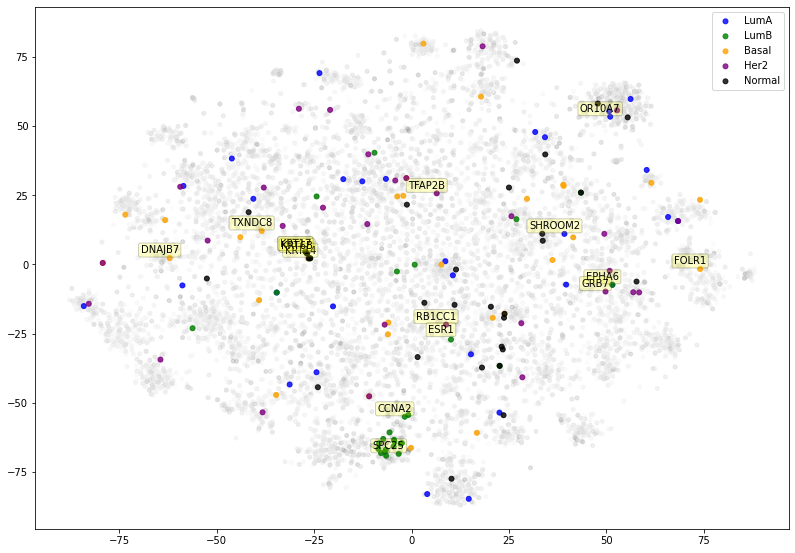

In [416]:
plt.rcParams['figure.figsize'] = (13.5, 9.6)

fig = plt.figure()
ax = fig.add_subplot(111)

cdict = {0:(0.8, 0.8, 0.8, 0.01), 1: 'black', 2: 'blue', 3: 'green', 4: 'orange', 5: 'purple'}

sc = ax.scatter(projected_tsne[:, 0],
           projected_tsne[:, 1],
           c=np.sum([get_weights(model,dim) for dim in range(5)], axis = 0),
           cmap = cm.Greys,
           s=15,
           alpha=0.3)

cmaps = {0:cm.Purples, 1: cm.Blues, 2: cm.Greens, 3: cm.Oranges, 4: cm.Reds}

for dim in [1,2,3,4,0]:
    summed_weights = get_weights(model, dim=dim)
    points = np.array([[projected_tsne[i, 0], projected_tsne[i, 1], 0] for i in summed_weights.argsort()[-30:][::-1]])
    ax.scatter(points[:, 0],
               points[:, 1],
               c=[cdict[dim+1] for p in points],
#                cmap = cmaps[dim],
               label=list(pam50_lables.keys())[dim],
               s=25,
               alpha=0.8)
    
    for i in summed_weights.argsort()[-3:][::-1]:
        ax.annotate(X_train.columns[i], (projected_tsne[i,0], projected_tsne[i,1]), xytext=(-10,3),
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.2))

ax.legend()

w = np.sum([get_weights(model,dim) for dim in range(5)], axis = 0).argsort()[-10:][::-1]
for i in w[8:9]:
    ax.annotate(X_train.columns[i], (projected_tsne[i,0], projected_tsne[i,1]), xytext=(-10,5),
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.2))
    
# plt.title("High weight genes showed in the tSNE visualiation of the ontology embedding space")
# plt.savefig("../experiments/results/figures/viz_high_weights.eps", bbox_inches='tight', format='eps')

plt.show()

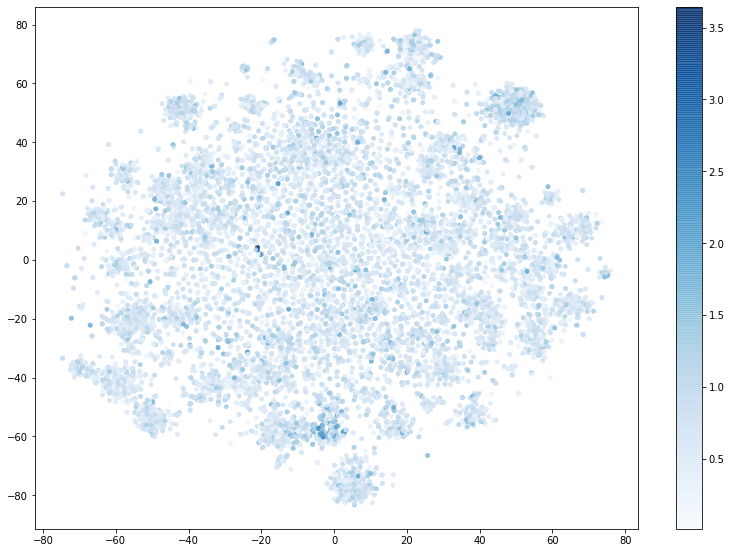

In [243]:
plt.rcParams['figure.figsize'] = (13.5, 9.6)

fig = plt.figure()
ax = fig.add_subplot(111)

sc = ax.scatter(projected_tsne[:, 0],
           projected_tsne[:, 1],
           c=np.sum([get_weights(model,dim) for dim in range(5)], axis = 0),
           cmap = cm.Blues,
           s=15,
           alpha=0.8)
cb = fig.colorbar(sc)

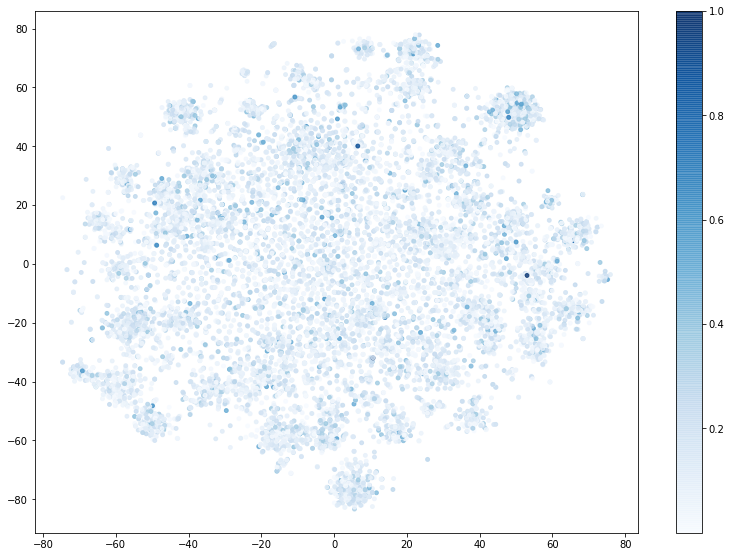

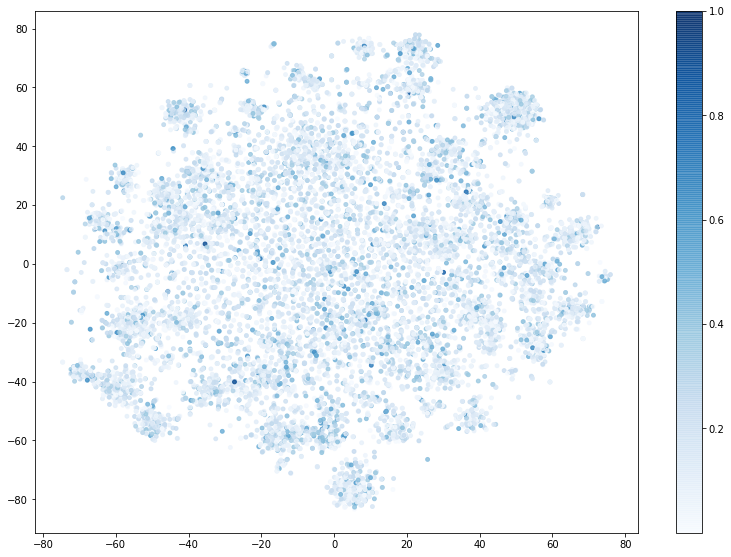

In [227]:
plt.rcParams['figure.figsize'] = (13.5, 9.6)

fig = plt.figure()
ax = fig.add_subplot(111)

sc = ax.scatter(projected_tsne[:, 0],
           projected_tsne[:, 1],
           c=get_weights(model,4),
           cmap = cm.Blues,
           s=15,
           alpha=0.8)
cb = fig.colorbar(sc)

fig = plt.figure()
ax = fig.add_subplot(111)
sc = ax.scatter(projected_tsne[:, 0],
           projected_tsne[:, 1],
           c=get_weights(model,3),
           cmap = cm.Blues,
           s=15,
           alpha=0.8)
cb = fig.colorbar(sc)

# fig.colorbar(sc);

In [419]:
df = df[df.ER_Status != '?']
target = df.pop('ER_Status')
labels = {
    'pos': 0,
    'neg': 1
}
target = target.apply(lambda x: labels[x])

In [426]:
# for nl in [1,2,3]:
#     for prepool in [0,1,2]:
#         for lr in [0.0001,0.0005,0.001]:
#             for seed in [0,1]:
model = models.gcn.GCN(name="GCN", 
                       dropout=True, 
                       cuda=True,
                       num_layer=1,
                       prepool_extralayers=0,
                       channels=2, 
                       embedding=2, 
                       aggregation=None,
                       lr=0.001,
                       num_epochs=100,
                       patience=30,
                       verbose=True,
                       seed=0
                      )
model.fit(X_train, y_train, adj) #, emb.cuda())

y_valid_pred = model.predict(X_valid)
print("###", sklearn.metrics.accuracy_score(y_valid, np.argmax(y_valid_pred,axis=1)))


Early stopping metric is accuracy_score
Reducing graph by a factor of 2 to 5865 nodes
epoch: 0, time: 0.24, valid_metric: 0.80, train_metric: 0.79
epoch: 1, time: 0.24, valid_metric: 0.93, train_metric: 0.91
epoch: 2, time: 0.24, valid_metric: 0.94, train_metric: 0.91
epoch: 3, time: 0.24, valid_metric: 0.94, train_metric: 0.91
epoch: 4, time: 0.24, valid_metric: 0.94, train_metric: 0.92
epoch: 5, time: 0.24, valid_metric: 0.94, train_metric: 0.94
epoch: 6, time: 0.24, valid_metric: 0.91, train_metric: 0.89
epoch: 7, time: 0.25, valid_metric: 0.94, train_metric: 0.94
epoch: 8, time: 0.24, valid_metric: 0.94, train_metric: 0.94
epoch: 9, time: 0.24, valid_metric: 0.94, train_metric: 0.94
epoch: 10, time: 0.24, valid_metric: 0.94, train_metric: 0.94
epoch: 11, time: 0.24, valid_metric: 0.93, train_metric: 0.94
epoch: 12, time: 0.25, valid_metric: 0.93, train_metric: 0.94
epoch: 13, time: 0.25, valid_metric: 0.93, train_metric: 0.94
epoch: 14, time: 0.25, valid_metric: 0.91, train_metric:

In [442]:
y_valid_pred = model.predict(X_valid)
print("###", sklearn.metrics.accuracy_score(y_valid, np.argmax(y_valid_pred,axis=1)))

### 0.92


In [443]:
get_weights(model, dim=0)

array([0.15838875, 0.06663743, 0.1750911 , ..., 0.06459436, 0.04578802,
       0.13955207], dtype=float32)

In [449]:
weights = model.my_logistic_layers[-1].weight[0]
weights = weights.cpu().detach().numpy()
weights = np.absolute(np.reshape(weights, (-1,2)))

for i in get_weights(model, dim=0).argsort()[-10:][::-1]:
    print(X_train.columns[i])
    print(weights[i])

# list(X_train.columns[get_weights(model, dim=0).argsort()[-10:][::-1]])

ESR1
[0.02471293 0.39112458]
CA2
[0.0206924  0.26241234]
WARS2
[0.01384306 0.25081176]
TFF1
[0.02036776 0.23963249]
STX19
[0.0273461  0.21745577]
LCN2
[0.00676617 0.2316981 ]
SMARCA1
[0.02410261 0.21235216]
ASRGL1
[0.00075819 0.22567566]
BEX1
[0.01897095 0.20359221]
KLK5
[0.0125619  0.20078848]


ValueError: 'c' argument has 11730 elements, which is inconsistent with 'x' and 'y' with size 11079.

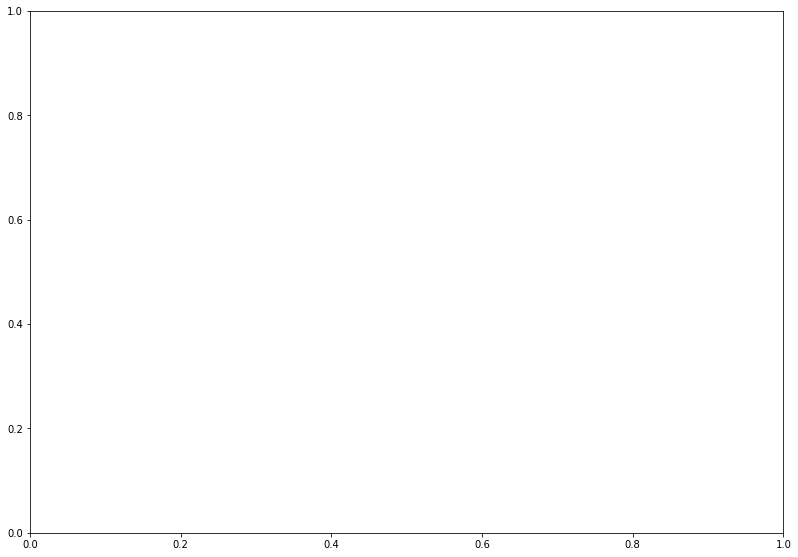

In [465]:
plt.rcParams['figure.figsize'] = (13.5, 9.6)

fig = plt.figure()
ax = fig.add_subplot(111)

cdict = {0:(0.8, 0.8, 0.8, 0.01), 1: 'black', 2: 'blue', 3: 'green', 4: 'orange', 5: 'purple'}

sc = ax.scatter(projected_tsne[:, 0],
           projected_tsne[:, 1],
           c=np.sum([get_weights(model,dim) for dim in range(2)], axis = 0),
           cmap = cm.Greys,
           s=15,
           alpha=0.3)

cmaps = {0:cm.Purples, 1: cm.Blues, 2: cm.Greens, 3: cm.Oranges, 4: cm.Reds}

for dim in [0,1]:
    summed_weights = get_weights(model, dim=dim)
    points = np.array([[projected_tsne[i, 0], projected_tsne[i, 1], 0] for i in summed_weights.argsort()[-100:][::-1]])
    ax.scatter(points[:, 0],
               points[:, 1],
               c=[cdict[dim+2] for p in points],
#                cmap = cmaps[dim],
               label=list(pam50_lables.keys())[dim],
               s=25,
               alpha=0.8)
    
    for i in summed_weights.argsort()[-3:][::-1]:
        ax.annotate(X_train.columns[i], (projected_tsne[i,0], projected_tsne[i,1]), xytext=(-10,3),
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.2))

ax.legend()

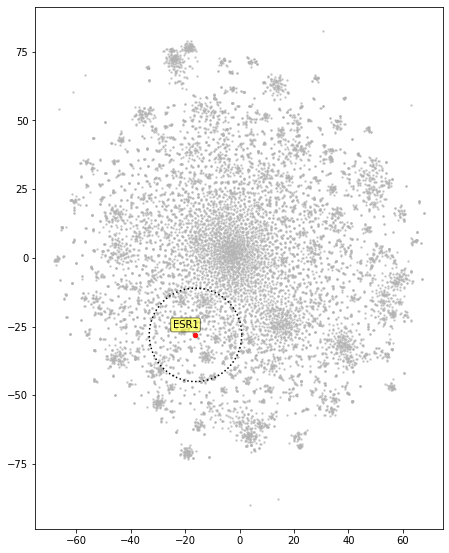

In [476]:
plt.rcParams['figure.figsize'] = (7.3, 9.6)

fig = plt.figure()
ax = fig.add_subplot(111)


sc = ax.scatter(projected_tsne[:, 0],
           projected_tsne[:, 1],
           c=(0.7,0.7,0.7),
           cmap = cm.Greys,
           s=2,
           alpha=0.6)


i = X_train.columns.get_loc('ESR1')
ax.scatter(projected_tsne[i, 0],
           projected_tsne[i, 1],
           c='red',
           s=20,
           alpha=0.9)


def xy(r,phi):
  return r*np.cos(phi) + projected_tsne[i, 0] , r*np.sin(phi) + projected_tsne[i, 1]

phis=np.arange(0,6.28,0.01)
r =17.
ax.plot( *xy(r,phis), c='black',ls=':' )

# for i in summed_weights.argsort()[-2:][::-1]:
ax.annotate(X_train.columns[i], (projected_tsne[i,0], projected_tsne[i,1]), xytext=(-10,5),
    textcoords='offset points', ha='center', va='bottom',
    bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5))

# plt.title("title")
plt.show()